In [ ]:
#!pip install --upgrade gspread_dataframe

In [1]:
from gspread_dataframe import set_with_dataframe, get_as_dataframe

In [2]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import auth
auth.authenticate_user()


import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

# Try to open the sheet, create it if it doesn't exist
sheet_name = "VR_Puzzle_Labels"

try:
    sheet = gc.open(sheet_name).sheet1
    print(f"Opened existing sheet: {sheet_name}")
except gspread.SpreadsheetNotFound:
    sheet = gc.create(sheet_name).sheet1
    print(f"Created new sheet: {sheet_name}")

Mounted at /content/drive
Opened existing sheet: VR_Puzzle_Labels


In [3]:
import glob
import pandas as pd
import numpy as np
import json
import re

# --------- ID Extraction ---------
def get_id(data):
    return re.sub(r'[^\d]', '', data.get("datetime", ""))

# --------- Relevant Object Position Extraction ---------
def get_object_positions(data):
    object_positions = {}
    relevant_names = [
        "Slot", "HandTracker_LEFT", "HandTracker_RIGHT",
        "FootLeft", "AnkleLeft", "KneeLeft", "HipLeft",
        "FootRight", "AnkleRight", "KneeRight", "HipRight",
        "HandTipLeft", "ThumbLeft", "HandLeft", "WristLeft", "ElbowLeft", "ShoulderLeft",
        "HandTipRight", "ThumbRight", "HandRight", "WristRight", "ElbowRight", "ShoulderRight",
        "SpineBase", "SpineMid", "SpineShoulder", "Neck", "Head"
    ]

    for key, value in data["values"].items():
        name = value["Name"]
        if any(name in name_check for name_check in relevant_names):
            object_positions[name] = value["Position"]

    return object_positions

# --------- JSON Reading ---------
def read_json_data(path):
    entries = []
    for line in open(path):
        entry_data = {}
        entry = json.loads(line)
        entry_data['ID'] = get_id(entry)
        entry_data['Objects'] = get_object_positions(entry)
        entries.append(entry_data)
    return entries

# --------- Global ID Counter ---------
global_id_counter = 1

def get_global_id():
    global global_id_counter
    current_id = global_id_counter
    global_id_counter += 1
    return current_id

# --------- DataFrame Conversion ---------
def data_to_dataframe(data_entries):
    records = []

    for entry in data_entries:
        record = {'GlobalID': get_global_id(), 'EntryID': entry['ID']}

        # Flatten all object positions
        for obj in entry['Objects']:
            record[f'{obj}_X'] = entry['Objects'][obj][0]
            record[f'{obj}_Y'] = entry['Objects'][obj][1]
            record[f'{obj}_Z'] = entry['Objects'][obj][2]

        # Placeholder labels
        for label in ['Spatial', 'Temporal', 'Spatial_1', 'Temporal_1', 'Spatial_2', 'Temporal_2']:
            record[label] = ''

        records.append(record)

    return pd.DataFrame(records, dtype=str)

In [4]:
# === ONE CELL: build df from /content/drive/MyDrive/VR_Puzzle -> compute & print limits ===
import os, numpy as np, pandas as pd

# Uses your existing: read_json_data(path), data_to_dataframe(data_entries)

root_path = '/content/drive/MyDrive/VR_Puzzle'

# 1) Gather all per-folder DataFrames
dfs = []
for folder_name in os.listdir(root_path):
    folder_path = os.path.join(root_path, folder_name)
    json_path = os.path.join(folder_path, 'raw_data.json')
    if os.path.exists(json_path):
        data_entries = read_json_data(json_path)
        if data_entries:
            df_part = data_to_dataframe(data_entries)
            dfs.append(df_part)

if not dfs:
    raise RuntimeError("No data found. Make sure there are subfolders with 'raw_data.json' under /content/drive/MyDrive/VR_Puzzle.")

df = pd.concat(dfs, ignore_index=True)

# 2) Compute fixed limits on SKELETON joints only (ignores Slot/HandTracker_*)
skeleton_joints = [
    "FootLeft","AnkleLeft","KneeLeft","HipLeft",
    "FootRight","AnkleRight","KneeRight","HipRight",
    "HandTipLeft","ThumbLeft","HandLeft","WristLeft","ElbowLeft","ShoulderLeft",
    "HandTipRight","ThumbRight","HandRight","WristRight","ElbowRight","ShoulderRight",
    "SpineBase","SpineMid","SpineShoulder","Neck","Head"
]

def _axis_limits(df, joints, axis, pad=0.10, use_percentiles=True, q=(1.0, 99.0)):
    cols = [f"{j}_{axis}" for j in joints if f"{j}_{axis}" in df.columns]
    if not cols:
        return (-1.0, 1.0)
    vals = pd.to_numeric(df[cols].values.ravel(), errors='coerce')
    vals = vals[~np.isnan(vals)]
    if vals.size == 0:
        return (-1.0, 1.0)
    if use_percentiles:
        vmin, vmax = np.percentile(vals, [q[0], q[1]])
    else:
        vmin, vmax = float(np.min(vals)), float(np.max(vals))
    span = vmax - vmin
    if span <= 0: span = 1.0
    return (float(vmin - pad*span), float(vmax + pad*span))

xlim = _axis_limits(df, skeleton_joints, 'X', pad=0.10, use_percentiles=True, q=(1.0, 99.0))
ylim = _axis_limits(df, skeleton_joints, 'Y', pad=0.10, use_percentiles=True, q=(1.0, 99.0))
zlim = _axis_limits(df, skeleton_joints, 'Z', pad=0.10, use_percentiles=True, q=(1.0, 99.0))

print("Global axis limits (percentile-clamped with 10% padding):")
print("X:", xlim)
print("Y:", ylim)
print("Z:", zlim)

Global axis limits (percentile-clamped with 10% padding):
X: (-11.269524344, 10.932840424000002)
Y: (-12.397386692, 11.231087212)
Z: (8.831583228, 17.974794252)


## Spartial View

In [11]:
# Bone group mapping (limbs)
limb_groups = {
    'left_leg': [
        ("FootLeft", "AnkleLeft"),
        ("AnkleLeft", "KneeLeft"),
        ("KneeLeft", "HipLeft"),
        ("HipLeft", "SpineBase"),
    ],
    'right_leg': [
        ("FootRight", "AnkleRight"),
        ("AnkleRight", "KneeRight"),
        ("KneeRight", "HipRight"),
        ("HipRight", "SpineBase"),
    ],
    'left_arm': [
        ("HandTipLeft", "HandLeft"),
        ("ThumbLeft", "HandLeft"),
        ("HandLeft", "WristLeft"),
        ("WristLeft", "ElbowLeft"),
        ("ElbowLeft", "ShoulderLeft"),
        ("ShoulderLeft", "SpineShoulder"),
    ],
    'right_arm': [
        ("HandTipRight", "HandRight"),
        ("ThumbRight", "HandRight"),
        ("HandRight", "WristRight"),
        ("WristRight", "ElbowRight"),
        ("ElbowRight", "ShoulderRight"),
        ("ShoulderRight", "SpineShoulder"),
    ],
    'spine': [
        ("SpineBase", "SpineMid"),
        ("SpineMid", "SpineShoulder"),
        ("SpineShoulder", "Neck"),
        ("Neck", "Head"),
    ]
}

# Color for each limb group
limb_colors = {
        'spine': 'brown',
        'left_arm': 'cyan',
        'right_arm': 'fuchsia',
        'left_leg': 'red',
        'right_leg': 'green'
    }

def plot_skeleton_on_ax(row, ax=None, label=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    # -- Special colored bones --
    special_bone_colors = {
        ("HandTipRight", "HandRight"): "orange",
        ("ThumbRight", "HandRight"): "lime",
        ("HandTipLeft", "HandLeft"): "orange",
        ("ThumbLeft", "HandLeft"): "lime"
    }

    # -- Special joint colors --
    special_joint_colors = {
        "HandTipLeft": "orange",
        "HandTipRight": "lime",
        "ThumbLeft": "orange",
        "ThumbRight": "lime"
    }

    # -- Special pairs to connect with a line --
    special_joint_pairs = [
        ("HandTipLeft", "ThumbLeft"),
        ("HandTipRight", "ThumbRight"),
    ]


    # -- Plot joints (special + default) --
    all_joints = set(j for group in limb_groups.values() for pair in group for j in pair)
    for joint in all_joints:
        try:
            x = float(row[f"{joint}_X"])
            y = float(row[f"{joint}_Y"])
            z = float(row[f"{joint}_Z"])
            color = 'blue'
            ax.scatter(x, y, z, color=color, s=5 if joint in special_joint_colors else 10)
        except KeyError:
            continue

    # -- Plot bones with group or special color --
    for limb, connections in limb_groups.items():
        default_color = limb_colors.get(limb, 'gray')
        for j1, j2 in connections:
            try:
                x = [float(row[f"{j1}_X"]), float(row[f"{j2}_X"])]
                y = [float(row[f"{j1}_Y"]), float(row[f"{j2}_Y"])]
                z = [float(row[f"{j1}_Z"]), float(row[f"{j2}_Z"])]

                # Handle reverse tuple for bone color override
                if (j1, j2) in special_bone_colors:
                    color = special_bone_colors[(j1, j2)]
                elif (j2, j1) in special_bone_colors:
                    color = special_bone_colors[(j2, j1)]
                else:
                    color = default_color

                ax.plot(x, y, z, color=color, linewidth=2)
            except KeyError:
                continue

    # -- Draw special joint-to-joint connections (lime/orange) --
    for j1, j2 in special_joint_pairs:
        try:
            x = [float(row[f"{j1}_X"]), float(row[f"{j2}_X"])]
            y = [float(row[f"{j1}_Y"]), float(row[f"{j2}_Y"])]
            z = [float(row[f"{j1}_Z"]), float(row[f"{j2}_Z"])]

            # Use the color of the first joint (or mix if you prefer)
            color = special_joint_colors.get(j1, 'black')
            ax.plot(x, y, z, color=color, linewidth=4, linestyle="--")  # dashed to highlight
        except KeyError:
            continue


    # -- Axes and title --
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    if label:
        ax.set_title(label)

    # -- Fixed scale (from your computed limits) --
    ax.set_xlim(-12, 12)   # X range
    ax.set_ylim(-13, 13)   # Y range
    ax.set_zlim(8, 18)     # Z range
    try:
        ax.set_box_aspect((24, 26, 10))  # keep proportions consistent
    except Exception:
        pass

    return ax

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

def generate_data_and_plots_for_all_folders(root_path):
    for folder_name in os.listdir(root_path):
        folder_path = os.path.join(root_path, folder_name)
        json_path = os.path.join(folder_path, 'raw_data.json')
        plot_log_path = os.path.join(folder_path, 'plot_log')
        os.makedirs(plot_log_path, exist_ok=True)

        if os.path.exists(json_path):
            print(f"📂 Processing: {folder_name}")
            data = read_json_data(json_path)
            #print(len(data))
            df = data_to_dataframe(data)
            #print(len(df))

            # Save CSV
            csv_path = os.path.join(folder_path, 'skeleton_data.csv')
            df.to_csv(csv_path, index=False)

            # Generate plots
            for _, row in df.iterrows():
                entry_id = row['EntryID']
                # view_configs = [
                #     ('view1', 20, 70),
                #     ('view2', -90, 90),
                #     ('view3', 40, 0)
                # ]

                view_configs = [
                    ('view1', 20, -60),
                    ('view2', -90, 90),
                    ('view3', 0, 20)
                ]


                for view_name, elev, azim in view_configs:
                    fig = plt.figure()
                    ax = fig.add_subplot(111, projection='3d')
                    ax.view_init(elev=elev, azim=azim)
                    plot_skeleton_on_ax(row, ax)
                    plt.tight_layout()
                    fig.savefig(os.path.join(plot_log_path, f"{entry_id}_{view_name}.png"))
                    plt.close(fig)

generate_data_and_plots_for_all_folders('/content/drive/MyDrive/VR_Puzzle')

📂 Processing: puzzle02


📂 Processing: puzzle02


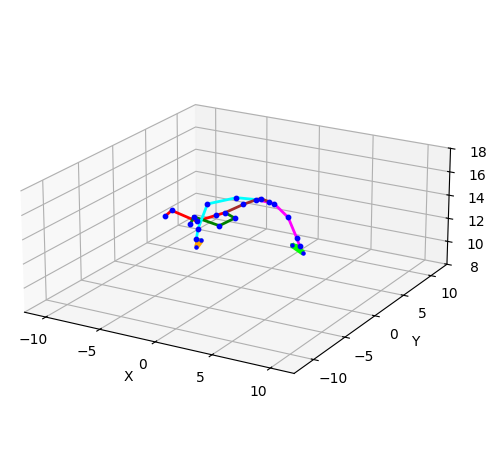

✅ Saved: /content/drive/MyDrive/VR_Puzzle/puzzle02/plot_log/08062025061613102_view1.png


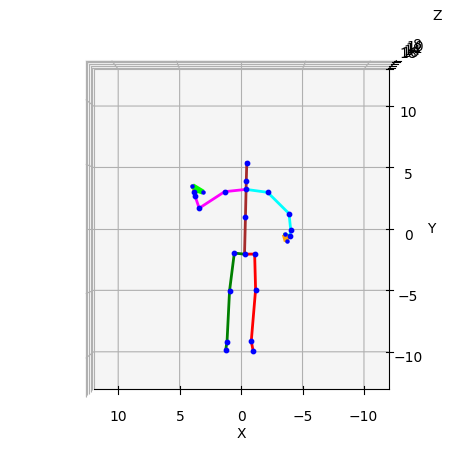

✅ Saved: /content/drive/MyDrive/VR_Puzzle/puzzle02/plot_log/08062025061613102_view2.png


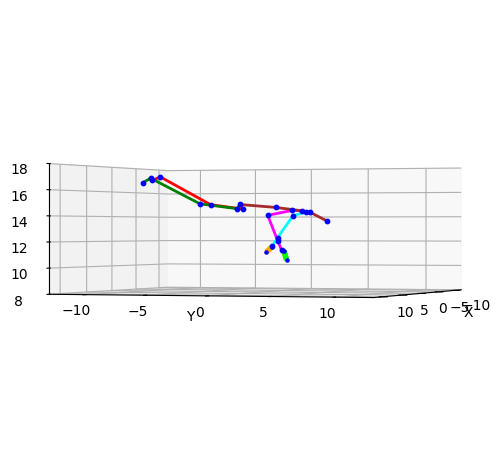

✅ Saved: /content/drive/MyDrive/VR_Puzzle/puzzle02/plot_log/08062025061613102_view3.png


In [8]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# Your existing functions should be defined already:
# - read_json_data()
# - data_to_dataframe()
# - plot_skeleton_on_ax()

def generate_missing_views_for_entry(root_path, folder_name, target_entry_id):
    folder_path = os.path.join(root_path, folder_name)
    json_path = os.path.join(folder_path, 'raw_data.json')
    plot_log_path = os.path.join(folder_path, 'plot_log')
    os.makedirs(plot_log_path, exist_ok=True)

    if os.path.exists(json_path):
        print(f"📂 Processing: {folder_name}")
        data = read_json_data(json_path)
        df = data_to_dataframe(data)

        # Find the row for the specific EntryID
        row = df[df["EntryID"] == target_entry_id]
        if row.empty:
            print(f"❌ EntryID {target_entry_id} not found in {folder_name}")
            return
        row = row.iloc[0]

        view_configs = [
                    ('view1', 20, -60),
                    ('view2', -90, 90),
                    ('view3', 0, 20)
        ]

        for view_name, elev, azim in view_configs:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.view_init(elev=elev, azim=azim)
            plot_skeleton_on_ax(row, ax)
            plt.tight_layout()
            plt.show()
            save_path = os.path.join(plot_log_path, f"{target_entry_id}_{view_name}.png")
            fig.savefig(save_path)
            plt.close(fig)
            print(f"✅ Saved: {save_path}")

# Run for specific case
generate_missing_views_for_entry(
    root_path='/content/drive/MyDrive/VR_Puzzle',
    folder_name='puzzle02',
    target_entry_id='08062025061613102'
)

## Interactive View

In [ ]:
def plot_skeleton_interaction_on_ax(row, ax=None, label=None):
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.spatial.transform import Rotation as R

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    # --- Limb groups ---
    limb_groups = {
        'left_leg': [
            ("FootLeft", "AnkleLeft"),
            ("AnkleLeft", "KneeLeft"),
            ("KneeLeft", "HipLeft"),
            ("HipLeft", "SpineBase"),
        ],
        'right_leg': [
            ("FootRight", "AnkleRight"),
            ("AnkleRight", "KneeRight"),
            ("KneeRight", "HipRight"),
            ("HipRight", "SpineBase"),
        ],
        'left_arm': [
            ("HandTipLeft", "HandLeft"),
            ("ThumbLeft", "HandLeft"),
            ("HandLeft", "WristLeft"),
            ("WristLeft", "ElbowLeft"),
            ("ElbowLeft", "ShoulderLeft"),
            ("ShoulderLeft", "SpineShoulder"),
        ],
        'right_arm': [
            ("HandTipRight", "HandRight"),
            ("ThumbRight", "HandRight"),
            ("HandRight", "WristRight"),
            ("WristRight", "ElbowRight"),
            ("ElbowRight", "ShoulderRight"),
            ("ShoulderRight", "SpineShoulder"),
        ],
        'spine': [
            ("SpineBase", "SpineMid"),
            ("SpineMid", "SpineShoulder"),
            ("SpineShoulder", "Neck"),
            ("Neck", "Head"),
        ]
    }

    limb_colors = {
        'spine': 'brown',
        'left_arm': 'cyan',
        'right_arm': 'fuchsia',
        'left_leg': 'red',
        'right_leg': 'green'
    }

    special_bone_colors = {
        ("HandTipRight", "HandRight"): "orange",
        ("ThumbRight", "HandRight"): "lime",
        ("HandTipLeft", "HandLeft"): "orange",
        ("ThumbLeft", "HandLeft"): "lime"
    }

    # -- Special joint colors --
    special_joint_colors = {
        "HandTipLeft": "orange",
        "HandTipRight": "lime",
        "ThumbLeft": "orange",
        "ThumbRight": "lime"
    }

    # -- Special pairs to connect with a line --
    special_joint_pairs = [
        ("HandTipLeft", "ThumbLeft"),
        ("HandTipRight", "ThumbRight"),
    ]


    # --- Collect joint positions ---
    joint_coords = {}
    all_bones = [bone for group in limb_groups.values() for bone in group]
    all_joints = set(j for pair in all_bones for j in pair)

    for joint in all_joints:
        try:
            joint_coords[joint] = (
                float(row[f'{joint}_X']),
                float(row[f'{joint}_Y']),
                float(row[f'{joint}_Z'])
            )
        except KeyError:
            continue

    # --- Plot joints ---
    for joint, coord in joint_coords.items():
        color = 'blue'
        size = 5 if joint in special_joint_colors else 10
        ax.scatter(*coord, color=color, s=size)

    # --- Plot bones ---
    for limb, connections in limb_groups.items():
        default_color = limb_colors.get(limb, 'gray')
        for j1, j2 in connections:
            if j1 not in joint_coords or j2 not in joint_coords:
                continue
            x = [joint_coords[j1][0], joint_coords[j2][0]]
            y = [joint_coords[j1][1], joint_coords[j2][1]]
            z = [joint_coords[j1][2], joint_coords[j2][2]]

            # Allow override by special color (check both directions)
            if (j1, j2) in special_bone_colors:
                color = special_bone_colors[(j1, j2)]
            elif (j2, j1) in special_bone_colors:
                color = special_bone_colors[(j2, j1)]
            else:
                color = default_color

            ax.plot(x, y, z, color=color, linewidth=2)

    # -- Draw special joint-to-joint connections (lime/orange) --
    for j1, j2 in special_joint_pairs:
        try:
            x = [float(row[f"{j1}_X"]), float(row[f"{j2}_X"])]
            y = [float(row[f"{j1}_Y"]), float(row[f"{j2}_Y"])]
            z = [float(row[f"{j1}_Z"]), float(row[f"{j2}_Z"])]

            # Use the color of the first joint (or mix if you prefer)
            color = special_joint_colors.get(j1, 'black')
            ax.plot(x, y, z, color=color, linewidth=4, linestyle="--")  # dashed to highlight
        except KeyError:
            continue

    # --- Axes & Fixed Scale ---
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    if label:
        ax.set_title(label)

    # ✅ Fixed limits (same as in plot_skeleton_on_ax)
    ax.set_xlim(-12, 12)   # X range
    ax.set_ylim(-13, 13)   # Y range
    ax.set_zlim(8, 18)     # Z range
    try:
        ax.set_box_aspect((24, 26, 10))  # keep proportions consistent
    except Exception:
        pass

    return ax


📂 Loading: puzzle02
🔍 Showing view1 (elev=20, azim=-60)


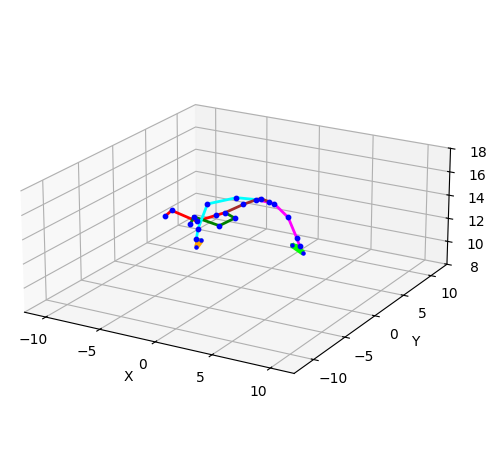

🔍 Showing view2 (elev=-90, azim=90)


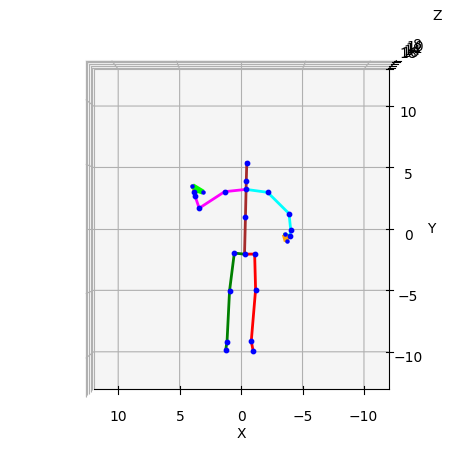

🔍 Showing view3 (elev=0, azim=20)


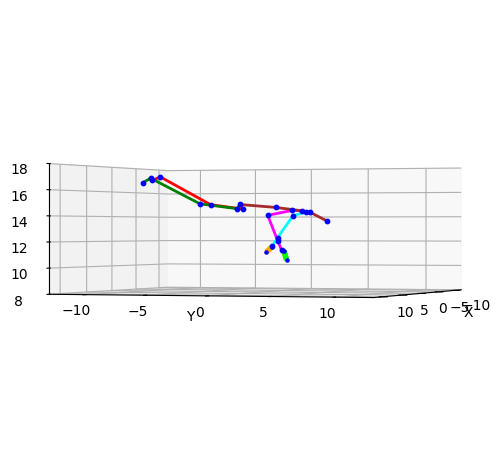

In [10]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# You still need these functions defined:
# - read_json_data()
# - data_to_dataframe()
# - plot_skeleton_interaction_on_ax() or plot_skeleton_on_ax()

def show_all_views_for_entry(root_path, folder_name, target_entry_id):
    folder_path = os.path.join(root_path, folder_name)
    json_path = os.path.join(folder_path, 'raw_data.json')

    if not os.path.exists(json_path):
        print(f"❌ JSON not found: {json_path}")
        return

    print(f"📂 Loading: {folder_name}")
    data = read_json_data(json_path)
    df = data_to_dataframe(data)

    row = df[df["EntryID"] == target_entry_id]
    if row.empty:
        print(f"❌ EntryID {target_entry_id} not found.")
        return
    row = row.iloc[0]

    # Define views
    view_configs = [
        ('view1', 20, -60),
        ('view2', -90, 90),
        ('view3', 0, 20)
    ]

    # Plot each view
    for view_name, elev, azim in view_configs:
        print(f"🔍 Showing {view_name} (elev={elev}, azim={azim})")
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(elev=elev, azim=azim)
        plot_skeleton_interaction_on_ax(row, ax=ax)
        plt.tight_layout()
        plt.show()

# Example usage
show_all_views_for_entry(
    root_path='/content/drive/MyDrive/VR_Puzzle',
    folder_name='puzzle02',
    target_entry_id='08062025061613102'
)

In [24]:
pip install gspread oauth2client gspread_dataframe

In [ ]:
import os
import pandas as pd
import gspread
from google.colab import auth
from gspread_dataframe import set_with_dataframe
from google.auth import default
from googleapiclient.discovery import build

# Authenticate and set up services
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
drive_service = build('drive', 'v3', credentials=creds)

# --------- Helper Functions ---------
def get_folder_id_by_path(path_list):
    """Walk through the path to get the folder ID."""
    parent_id = 'root'
    for name in path_list:
        query = f"mimeType='application/vnd.google-apps.folder' and trashed = false and name='{name}' and '{parent_id}' in parents"
        results = drive_service.files().list(q=query, spaces='drive', fields="files(id, name)", pageSize=10).execute()
        items = results.get('files', [])
        if not items:
            raise FileNotFoundError(f"Folder '{name}' not found under parent ID '{parent_id}'")
        parent_id = items[0]['id']
    return parent_id

# def get_public_image_link(file_name, folder_id):
#     """Find the file in Drive, make it public, and return an IMAGE formula for Sheets."""
#     query = f"name='{file_name}' and '{folder_id}' in parents and trashed = false"
#     results = drive_service.files().list(q=query, fields="files(id, name)").execute()
#     items = results.get('files', [])
#     if not items:
#         return ""  # Skip if image not found

#     file_id = items[0]['id']

#     # Make it public
#     try:
#         drive_service.permissions().create(
#             fileId=file_id,
#             body={"role": "reader", "type": "anyone"},
#             fields="id"
#         ).execute()
#     except:
#         pass  # Permission might already exist

#     # Create direct image link
#     public_url = f"https://drive.google.com/uc?export=download&id={file_id}"
#     return f'=IMAGE("{public_url}")'

def get_public_image_link(file_name, folder_id):
    """Find the file in Drive, make it public, and return an IMAGE formula for Sheets."""
    query = f"name='{file_name}' and '{folder_id}' in parents and trashed = false"
    results = drive_service.files().list(q=query, fields="files(id, name)").execute()
    items = results.get('files', [])
    if not items:
        return ""  # Skip if image not found

    file_id = items[0]['id']

    # Make it public
    try:
        drive_service.permissions().create(
            fileId=file_id,
            body={"role": "reader", "type": "anyone"},
            fields="id"
        ).execute()
    except:
        pass  # Permission might already exist

    # Return formula for Sheets
    public_url = f"https://drive.google.com/uc?export=view&id={file_id}"
    return f'=IMAGE("{public_url}")'



# --------- Base Setup ---------
base_path = "/content/drive/MyDrive/VR_Puzzle"
folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

# --------- Main Loop for Each Folder ---------
for folder in folders:
    print(f"📁 Processing folder: {folder}")
    try:
        # Get Google Drive folder IDs for plot_log and image_log
        plot_folder_id = get_folder_id_by_path(["VR_Puzzle", folder, "plot_log"])
        image_folder_id = get_folder_id_by_path(["VR_Puzzle", folder, "image_log"])
    except FileNotFoundError as e:
        print(f"⚠️ Skipping {folder}: {e}")
        continue

    # Get EntryIDs from plot_log view1 files
    local_plot_path = os.path.join(base_path, folder, "plot_log")
    entry_ids = sorted(set(
        fname.split('_')[0]
        for fname in os.listdir(local_plot_path)
        if fname.endswith('.png') and '_view1' in fname
    ))

    # Build dataframe
    records = []
    for entry_id in entry_ids:
        record = {
            "EntryID": entry_id,
            "view1": get_public_image_link(f"{entry_id}_view1.png", plot_folder_id),
            "view2": get_public_image_link(f"{entry_id}_view2.png", plot_folder_id),
            "view3": get_public_image_link(f"{entry_id}_view3.png", plot_folder_id),
            "Image": get_public_image_link(f"{entry_id}.png", image_folder_id),
            "Spatial 1": "", "Spatial 2": "", "Spatial": "",
            "interaction_view1": get_public_image_link(f"{entry_id}_interaction_view1.png", plot_folder_id),
            "interaction_view2": get_public_image_link(f"{entry_id}_interaction_view2.png", plot_folder_id),
            "interaction_view3": get_public_image_link(f"{entry_id}_interaction_view3.png", plot_folder_id),
            "image": get_public_image_link(f"{entry_id}.png", image_folder_id),
            "Temporal1": "", "Temporal2": "", "Temporal": ""
        }
        records.append(record)

    df = pd.DataFrame(records)

    # Create Google Sheet
    sheet_title = f"{folder}_LabelSheet"
    try:
        sh = gc.create(sheet_title)
        worksheet = sh.get_worksheet(0)
        set_with_dataframe(worksheet, df)
        print(f"✅ Created sheet: {sheet_title}")
    except Exception as e:
        print(f"❌ Failed to create sheet for {folder}: {e}")

📁 Processing folder: puzzle02
✅ Created sheet: puzzle02_LabelSheet
